<a href="https://colab.research.google.com/github/longbui23/Amazon-Sentiment-Analysis/blob/main/ttest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **T-TEST BETWEEN DIFFERENT PRICE RANGE**

## **1) Data Cleaning**

In [96]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/ECON314: Amazon-Sentiment-Analysis

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ECON314: Amazon-Sentiment-Analysis


In [97]:
#import libraries
import numpy as np
import pandas as pd

import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind


import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

In [98]:
#import data
df = pd.read_csv("Data/sentiment.csv")
df.head()

,reviewID,Product Name,Brand Name,Price,Rating,Review,Review Votes,Review Length,sentimentScore,sentiment
0,0,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,3,"this phone was a replacement for my niece, her...",4.0,642,0.003940,Neutral with Negative Feedback
1,1,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,5,Dual Sims are better than one sim has blurred ...,2.0,51,0.625000,positive
2,2,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,5,Nice phone. I am waiting to be upgraded to Win...,2.0,53,0.600000,positive
3,3,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,1,I did not receive my order items.,0.0,33,0.000000,Neutral with Negative Feedback
4,4,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,1,"First off, great service as usual. I wanted a ...",5.0,1164,0.077216,Neutral with Negative Feedback


**Price Range Segmentation**

In [99]:
#classify price range
priceRange = []

for price in df['Price']:
    if price < 71.05:
        priceRange.append("Low price")
    elif 71.05 <= price < 116.99:
        priceRange.append("Low-Mid price")
    elif 116.99 <= price < 325.16:
        priceRange.append("Mid price")
    elif 325.16 <= price < 622.9:
        priceRange.append("Higher-mid price")
    else:
        priceRange.append("High-end price")


In [100]:
#add a new column to the data
df['Price Ranges'] = priceRange

df['Price Ranges'].value_counts()

Mid price           65831
Low price           36143
Low-Mid price       36046
Higher-mid price    16201
High-end price       1589
Name: Price Ranges, dtype: int64

In [101]:
df.columns

Index(['reviewID', 'Product Name', 'Brand Name', 'Price', 'Rating', 'Review',
       'Review Votes', 'Review Length', 'sentimentScore', 'sentiment',
       'Price Ranges'],
      dtype='object')

## **2) Functions for t-test**

### Function to remove outliers: remove_outliers(df, col)

In [102]:
def remove_outliers(df, col):
    '''Find lower and upper bounds of the given column of the df and remove outliers'''

    # Extract the specified column from the DataFrame
    column = df[col]

    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    #display outlier
    print("Lower Bound is", lower_bound)
    print("Upper Bound is", upper_bound)

    sns.boxplot(df[col])
    plt.ylabel(col + " original")
    plt.show()

    # Filter
    df_filtered = df[(df[col] > lower_bound) & (df[col] < upper_bound)]

    #display
    print(f"{col} after removing outlier:")
    print(df_filtered[col].describe())


    return df_filtered

### Function to plot distribution between group prices: plot_price_range_histograms(df, col, segment_col)

In [103]:
def plot_price_range_histograms(df, col, segment_col):
    '''Plot histograms for each price range'''

    # Create a figure and subplots
    fig, axs = plt.subplots(1, len(segment_col), figsize=(15, 6), sharey=True)

    # Iterate through each price range
    for i, price_range in enumerate(segment_col):
        # Filter data for the current price range
        price_range_reviews = df[df['Price Ranges'] == price_range][col]

        # Plot histogram for the current price range
        axs[i].hist(price_range_reviews, bins=30, alpha=0.5, label=price_range)
        axs[i].set_title(f'Histogram of {price_range}')
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
        axs[i].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

### Function for t-test: perform_pairwise_ttests(df, col, col_segment)

In [104]:
def perform_pairwise_ttests(df, col, col_segment):
    '''Perform pairwise t-tests between all combinations of price ranges'''

    #col sengment to list
    col_range = df_interquantile[col_segment].unique()

    # Iterate through all combinations of price ranges
    for col_range1, col_range2 in combinations(col_range, 2):
        # Select the data for the two price ranges
        data1 = df[df['Price Ranges'] == col_range1][col]
        data2 = df[df['Price Ranges'] == col_range2][col]

        # Perform Levene's test to check for equal variances
        levene_test = stats.levene(data1, data2)

        if levene_test.pvalue >= 0.05:
            # If p-value from Levene's test is >= 0.05, use equal variance t-test
            t_statistic, p_value = stats.ttest_ind(data1, data2, equal_var=True)
        else:
            # If p-value from Levene's test is < 0.05, use Welch's t-test (unequal variance t-test)
            t_statistic, p_value = stats.ttest_ind(data1, data2, equal_var=False)

        # Print the results
        print(f"T-test results for {col_range1} vs {col_range2}:")
        print(f"Test statistic: {t_statistic:.15f}, p-value: {p_value:.15f}")
        if p_value < 0.05:
            print("The difference is statistically significant.")
        else:
            print("The difference is not statistically significant.")
        print()

## **3) T-test for different Price Range**

### **a) T-test for Count of Reviews on Price**

In [105]:
#count the total number of reviews for each price:
df['Reviews_Count'] = df.groupby('Price')['Review'].transform('count')

df.head()

,reviewID,Product Name,Brand Name,Price,Rating,Review,Review Votes,Review Length,sentimentScore,sentiment,Price Ranges,Reviews_Count
0,0,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,3,"this phone was a replacement for my niece, her...",4.0,642,0.003940,Neutral with Negative Feedback,Low price,53
1,1,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,5,Dual Sims are better than one sim has blurred ...,2.0,51,0.625000,positive,Low price,53
2,2,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,5,Nice phone. I am waiting to be upgraded to Win...,2.0,53,0.600000,positive,Low price,53
3,3,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,1,I did not receive my order items.,0.0,33,0.000000,Neutral with Negative Feedback,Low price,53
4,4,Acer Liquid M220 Windows 8.1 Smartphone - Black,ACER,34.95,1,"First off, great service as usual. I wanted a ...",5.0,1164,0.077216,Neutral with Negative Feedback,Low price,53


Lower Bound is -1103.5
Upper Bound is 2300.5


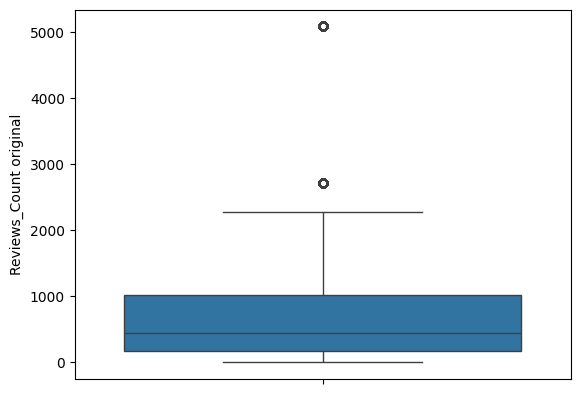

Reviews_Count after removing outlier:
count    148012.000000
mean        625.026619
std         601.941097
min           1.000000
25%         163.000000
50%         402.000000
75%         883.000000
max        2267.000000
Name: Reviews_Count, dtype: float64


In [106]:
df_interquantile = remove_outliers(df, 'Reviews_Count')

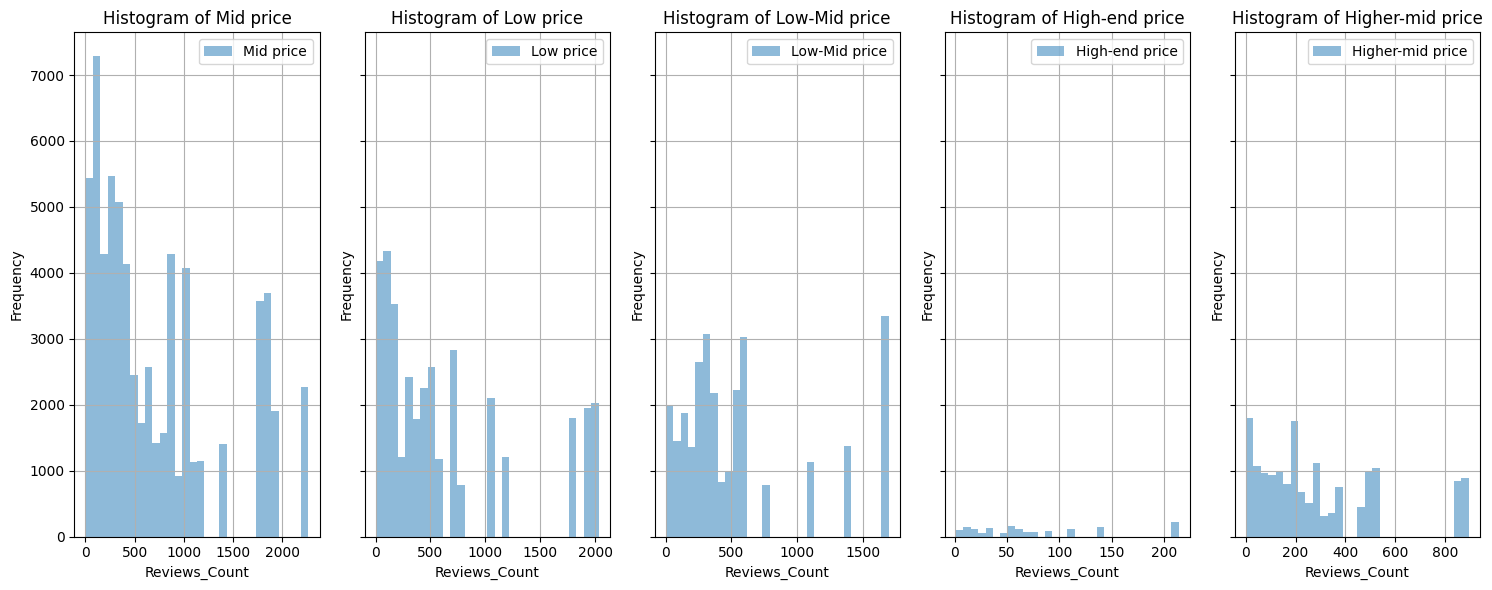

In [107]:
price_range = ['Mid price', 'Low price', 'Low-Mid price', 'High-end price', 'Higher-mid price']

plot_price_range_histograms(df_interquantile, "Reviews_Count", price_range)

<ipython-input-108-5e12031ce064>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interquantile['Reviews_Count_log10'] = np.log10(df['Reviews_Count'])


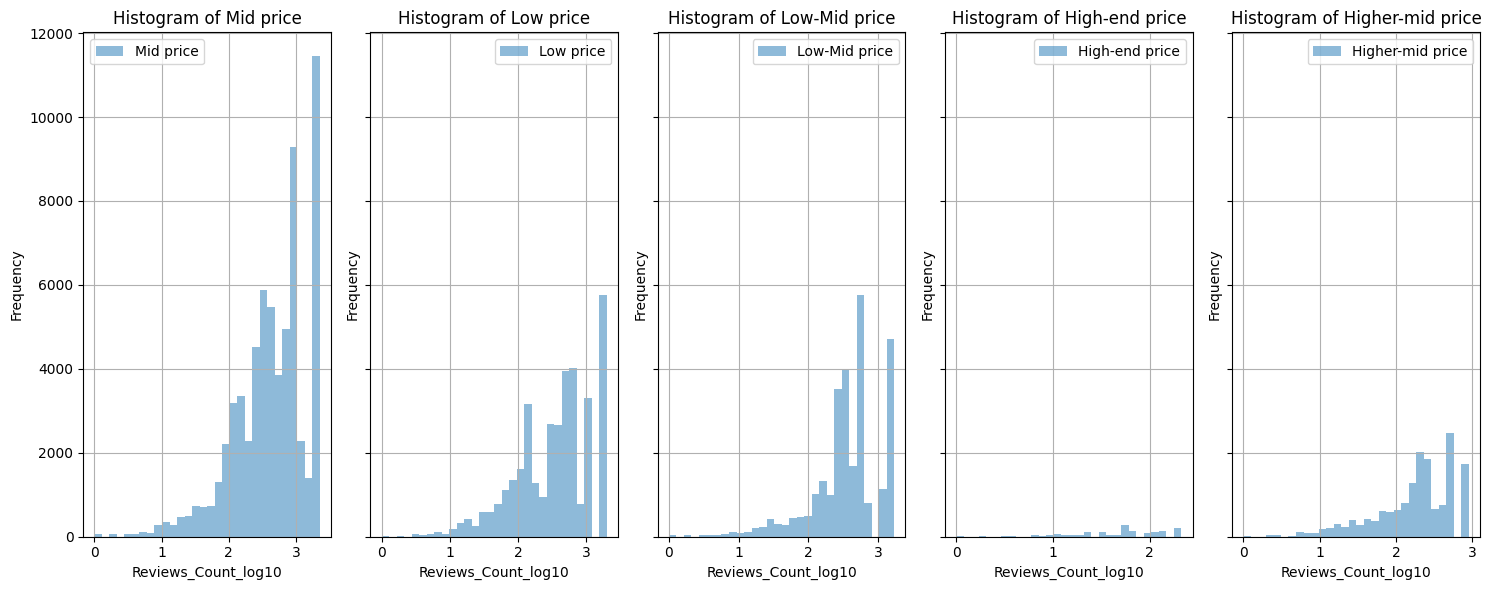

In [108]:
#we can see that the distribution is skewed. We will perform log10() transformation
df_interquantile['Reviews_Count_log10'] = np.log10(df['Reviews_Count'])

plot_price_range_histograms(df_interquantile, "Reviews_Count_log10", price_range)

In [109]:
perform_pairwise_ttests(df_interquantile, "Reviews_Count_log10", "Price Ranges")

T-test results for Low price vs Low-Mid price:
Test statistic: -6.218104714494628, p-value: 0.000000000506312
The difference is statistically significant.

T-test results for Low price vs Mid price:
Test statistic: -25.725319835207532, p-value: 0.000000000000000
The difference is statistically significant.

T-test results for Low price vs Higher-mid price:
Test statistic: 57.949136179175241, p-value: 0.000000000000000
The difference is statistically significant.

T-test results for Low price vs High-end price:
Test statistic: 67.824659770098961, p-value: 0.000000000000000
The difference is statistically significant.

T-test results for Low-Mid price vs Mid price:
Test statistic: -18.731992382895360, p-value: 0.000000000000000
The difference is statistically significant.

T-test results for Low-Mid price vs Higher-mid price:
Test statistic: 63.386720591482550, p-value: 0.000000000000000
The difference is statistically significant.

T-test results for Low-Mid price vs High-end price:
Tes

### **b) T-Test for Review Length and Price Range**

#### Data Transformation

Lower Bound is -282.5
Upper Bound is 625.5


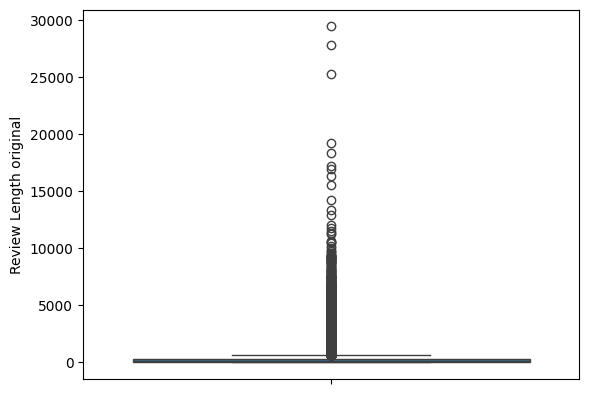

Review Length after removing outlier:
count    141002.000000
mean        159.828953
std         138.760800
min           1.000000
25%          52.000000
50%         119.000000
75%         222.000000
max         625.000000
Name: Review Length, dtype: float64


In [110]:
df_interquantile = remove_outliers(df, 'Review Length')

**Normal Distribution Assumption**

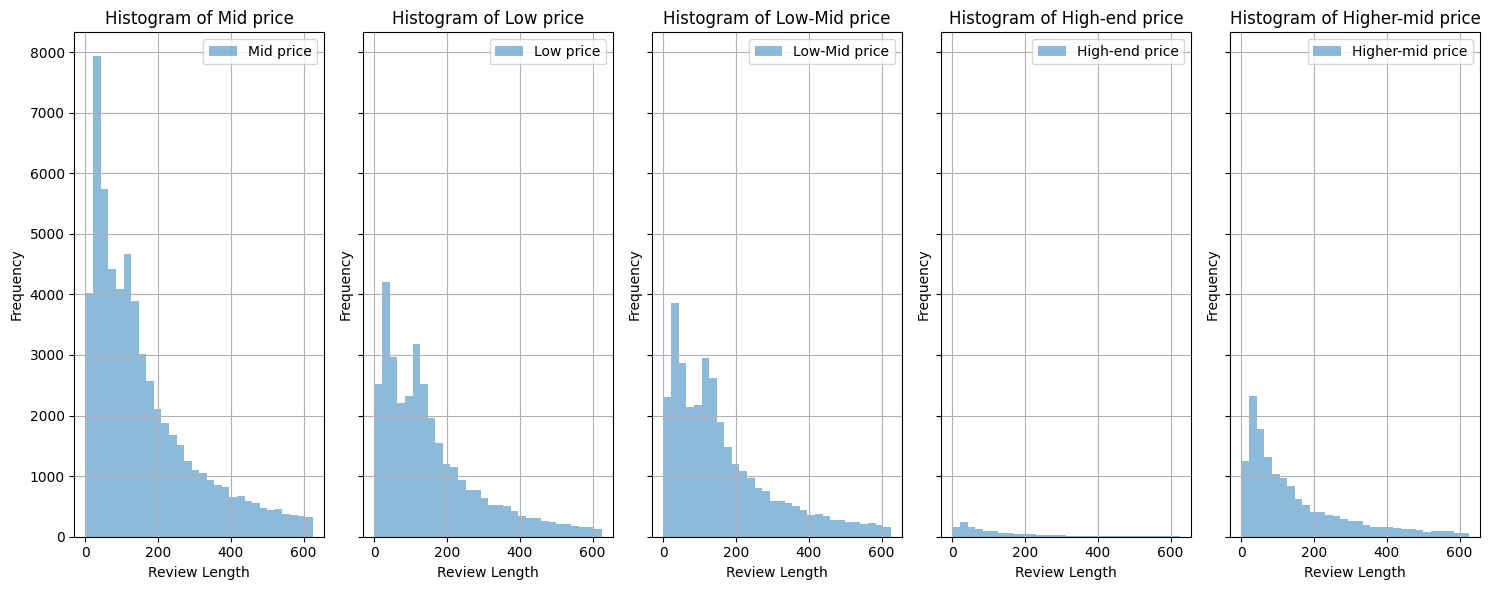

In [111]:
price_range = ['Mid price', 'Low price', 'Low-Mid price', 'High-end price', 'Higher-mid price']

plot_price_range_histograms(df_interquantile, 'Review Length', price_range)

In [112]:
#we can see that the distribution is skewed. We will perform log10() transformation
df_interquantile['Review Length log10'] = df_interquantile['Review Length'].apply(lambda x: 0 if x== 0 else np.log10(x))

<ipython-input-112-2fe7be4cc802>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interquantile['Review Length log10'] = df_interquantile['Review Length'].apply(lambda x: 0 if x== 0 else np.log10(x))


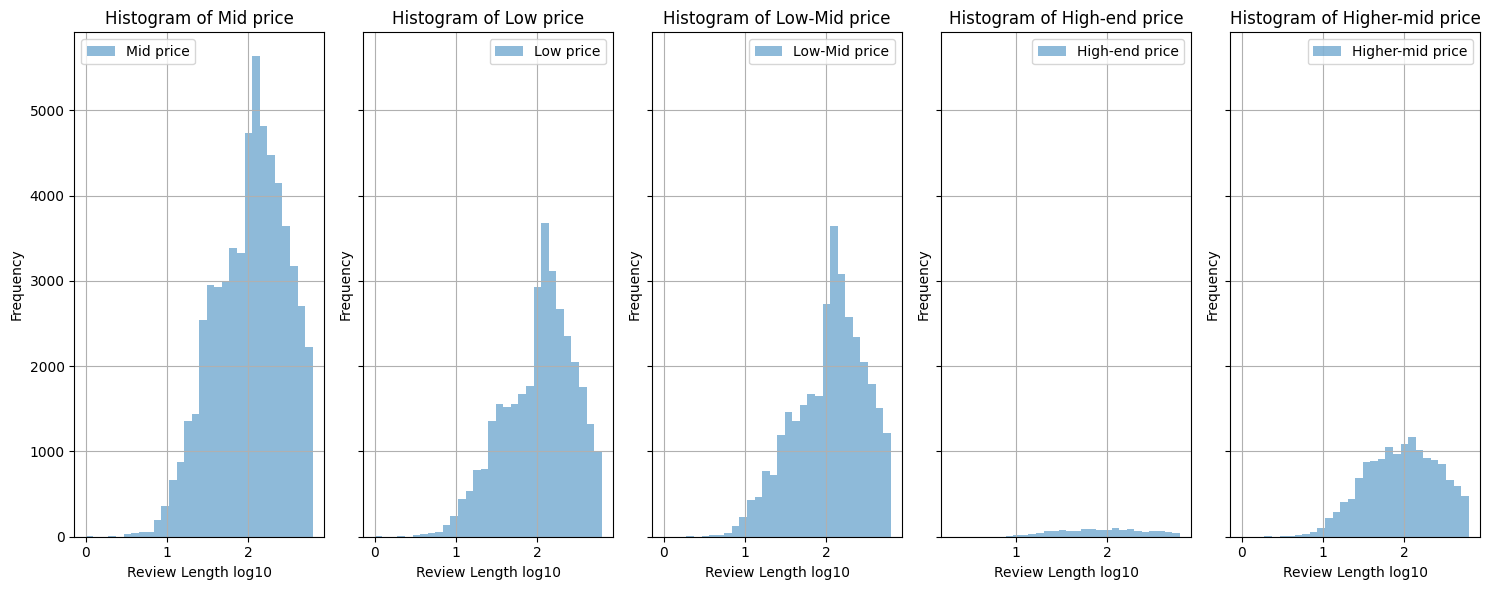

In [113]:
price_range = ['Mid price', 'Low price', 'Low-Mid price', 'High-end price', 'Higher-mid price']

plot_price_range_histograms(df_interquantile, 'Review Length log10', price_range)

#### T-test

In [114]:
perform_pairwise_ttests(df_interquantile, "Review Length", 'Price Ranges')

T-test results for Low price vs Low-Mid price:
Test statistic: -7.353186933773003, p-value: 0.000000000000196
The difference is statistically significant.

T-test results for Low price vs Mid price:
Test statistic: -4.553211449356636, p-value: 0.000005291881443
The difference is statistically significant.

T-test results for Low price vs Higher-mid price:
Test statistic: 8.462425468678356, p-value: 0.000000000000000
The difference is statistically significant.

T-test results for Low price vs High-end price:
Test statistic: 3.666868595871430, p-value: 0.000245903780056
The difference is statistically significant.

T-test results for Low-Mid price vs Mid price:
Test statistic: 3.686991232301525, p-value: 0.000227097190975
The difference is statistically significant.

T-test results for Low-Mid price vs Higher-mid price:
Test statistic: 13.913009042898139, p-value: 0.000000000000000
The difference is statistically significant.

T-test results for Low-Mid price vs High-end price:
Test sta

Conclusions: 0 p-value --> no co-incidence between 2 groups. Mean difference gradually increase by price range.

In [115]:
#get the mean number of reviews of all price ranges
df_interquantile.groupby('Price Ranges').agg({'Review Length':'mean'})

,Review Length
Price Ranges,
High-end price,144.258065
Higher-mid price,146.245607
Low price,157.555792
Low-Mid price,165.372349
Mid price,161.810162


### **c) T-test for Price Range and Rating**

#### Data Transformation

Lower Bound is -2.5
Upper Bound is 9.5


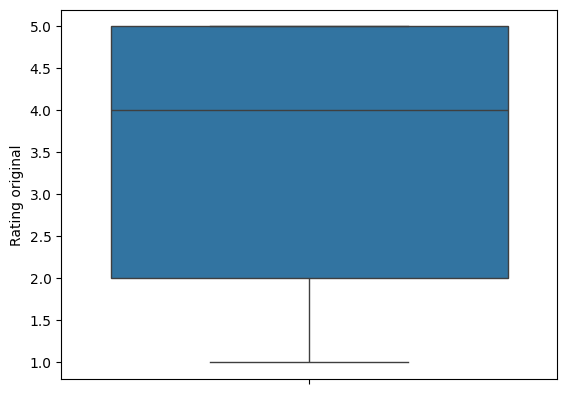

Rating after removing outlier:
count    155810.000000
mean          3.632899
std           1.598430
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64


In [116]:
df_interquantile = remove_outliers(df, 'Rating')

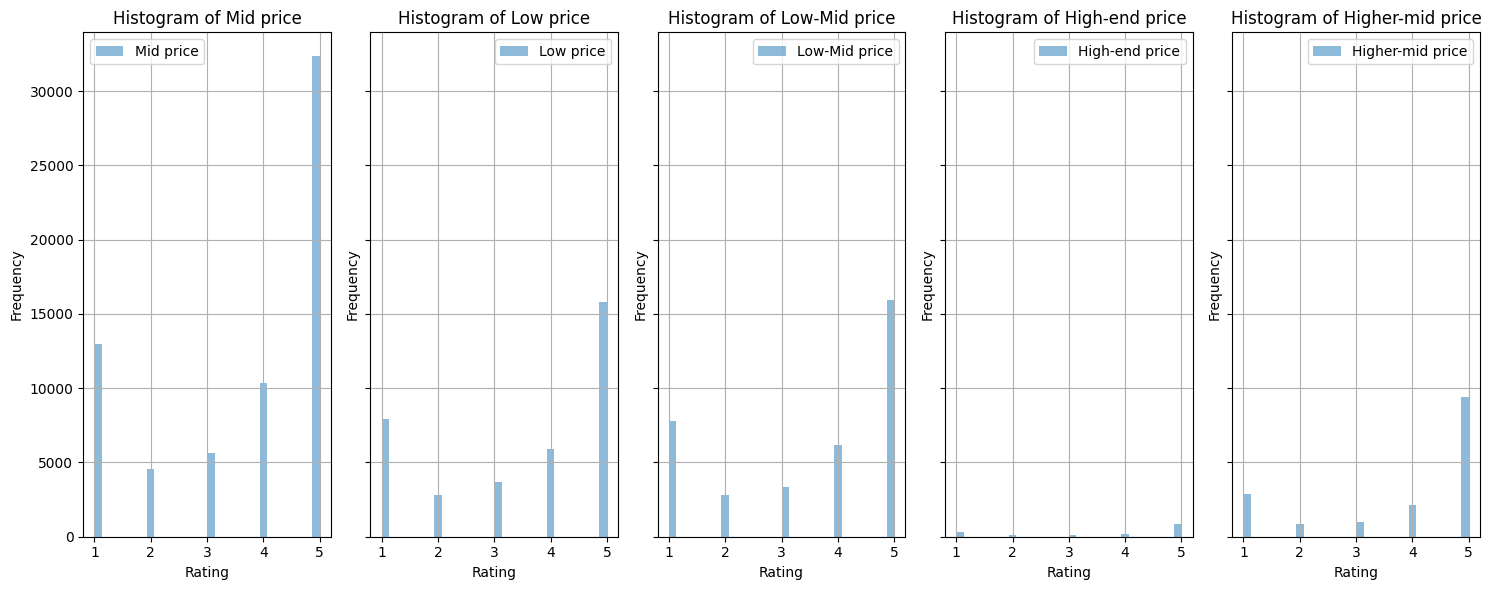

In [117]:
plot_price_range_histograms(df_interquantile, 'Rating', price_range)

In [118]:
#df_interquantile['Rating_sqrt'] =n p.sqrt(df['column'])

###  **d) T-test for Sentiment Score by different Price Range**

#### a) Data Transformation

Lower Bound is -0.7216030844155843
Upper Bound is 1.2026718073593072


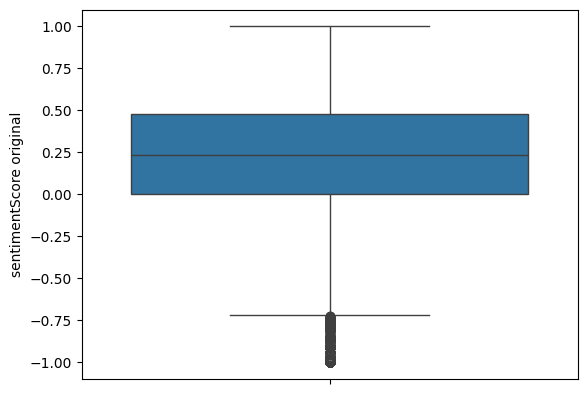

sentimentScore after removing outlier:
count    154617.000000
mean          0.266806
std           0.324835
min          -0.716667
25%           0.000000
50%           0.233917
75%           0.484167
max           1.000000
Name: sentimentScore, dtype: float64


In [119]:
df_interquantile = remove_outliers(df, 'sentimentScore')

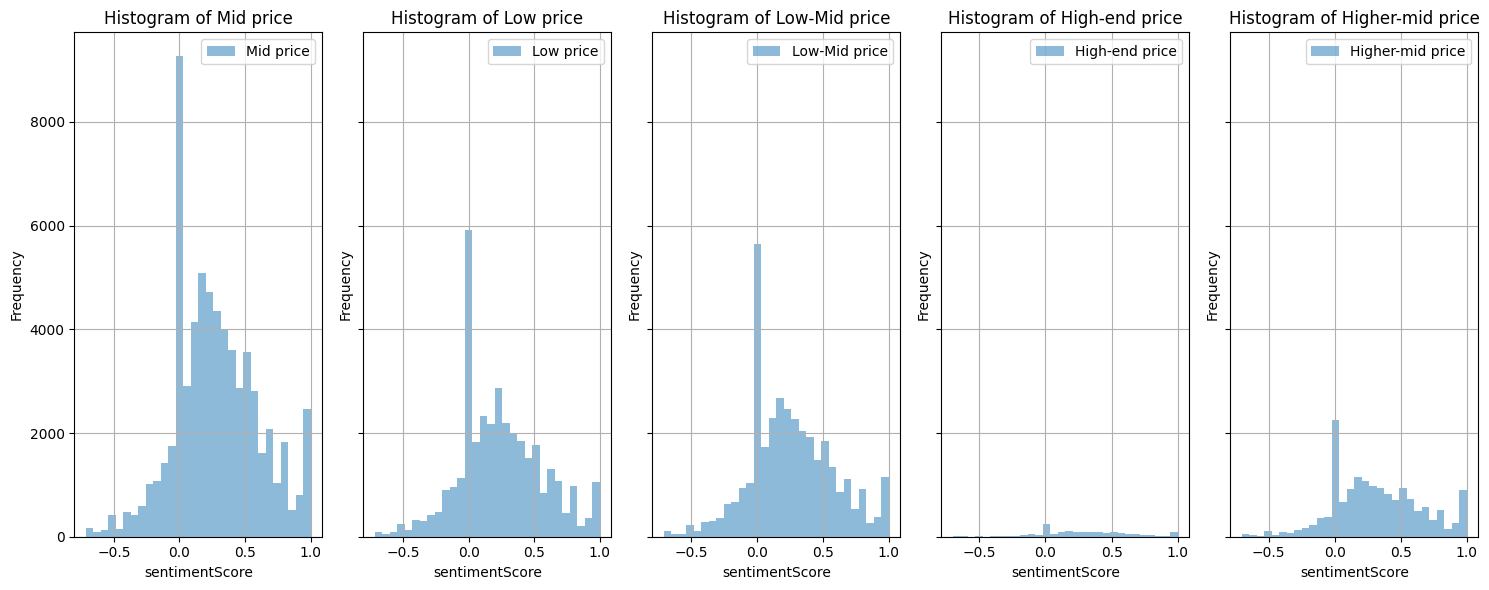

In [120]:
price_range = ['Mid price', 'Low price', 'Low-Mid price', 'High-end price', 'Higher-mid price']

plot_price_range_histograms(df_interquantile, "sentimentScore", price_range)

#### b) T-test

In [121]:
perform_pairwise_ttests(df_interquantile, "sentimentScore", "Price Ranges")

T-test results for Low price vs Low-Mid price:
Test statistic: -6.087225585566549, p-value: 0.000000001154657
The difference is statistically significant.

T-test results for Low price vs Mid price:
Test statistic: -17.233373220820926, p-value: 0.000000000000000
The difference is statistically significant.

T-test results for Low price vs Higher-mid price:
Test statistic: -23.844502634531448, p-value: 0.000000000000000
The difference is statistically significant.

T-test results for Low price vs High-end price:
Test statistic: -5.862522217103516, p-value: 0.000000005464199
The difference is statistically significant.

T-test results for Low-Mid price vs Mid price:
Test statistic: -10.317543145010577, p-value: 0.000000000000000
The difference is statistically significant.

T-test results for Low-Mid price vs Higher-mid price:
Test statistic: -19.192013049427757, p-value: 0.000000000000000
The difference is statistically significant.

T-test results for Low-Mid price vs High-end price:
T

In [122]:
df_interquantile.groupby('Price Ranges').agg({'sentimentScore':'mean'})

,sentimentScore
Price Ranges,
High-end price,0.291096
Higher-mid price,0.314735
Low price,0.239627
Low-Mid price,0.254283
Mid price,0.276171


### **e) T-test for Review Votes by different Price Range**

Lower Bound is nan
Upper Bound is nan


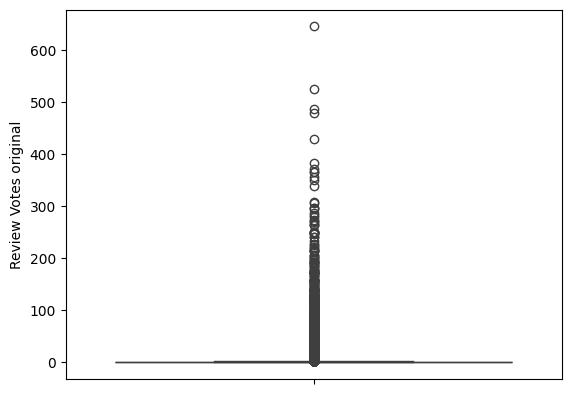

Review Votes after removing outlier:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Review Votes, dtype: float64


In [123]:
df_interquantile = remove_outliers(df, 'Review Votes')